# Data Exploration

In [2]:
# Load Assessment Items Data
from pyspark import SparkFiles

url = 'https://github.com/dlhinkley/c772-capstone-project/raw/master/data/assessment_items.csv'

spark.sparkContext.addFile(url)

file = "file://" + SparkFiles.get("assessment_items.csv")

dfRaw = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(file)

In [3]:
from pyspark import SparkFiles

url = 'https://github.com/dlhinkley/c772-capstone-project/raw/master/data/descriptions.csv'

spark.sparkContext.addFile(url)

file = "file://" + SparkFiles.get("descriptions.csv")

dfDesc = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(file)

In [4]:
import pandas as pd

pd.set_option('display.max_colwidth', None)
dfPanda = dfDesc.toPandas()
dfPanda

,field,type,description
0,assessment_id,Categorical Identifier,ID of an Assessment.
1,assessment_instance_attempt_id,Categorical Identifier,ID of a learner's attempt of an assessment.
2,assessment_instance_id,Categorical Identifier,ID of a section's instance of an assessment.
3,assessment_item_response_id,Categorical Identifier,ID of a learners response to an assessment item.
4,assigned_item_status,Categorical Nominal,"Code indicating the status of the assessment item. Example: assigned, responded, offline_scorred, etc."
5,assignment_attempt_number,Numeric Continuous,The nth time a certain learner attempted the assessement.
6,assignment_due_date,Categorical Interval,The date and time the assignment is due.
7,assignment_final_submission_date,Categorical Interval,The date and time the assignment was submitted for scoring.
8,assignment_late_submission,Categorical Binary,True if the assignment was submitted late.
9,assignment_max_attempts,Numeric Continuous,The number of times a learner can attempt the assessment.


In [5]:
from pyspark.sql.functions import col

# Save field names
identifierFieldRows = dfDesc.filter("type = 'Categorical Identifier'")
identifierFields = [row['field'] for row in identifierFieldRows.select("field").collect()]
identifierFieldRows.select(col("field").alias('Categorical Identifier')).show(20,False)

nominalFieldRows    = dfDesc.filter("type = 'Categorical Nominal'")
nominalFields = [row['field'] for row in nominalFieldRows.select("field").collect()]
nominalFieldRows.select(col("field").alias('Categorical Nominal')).show(20,False)

continousFieldRows  = dfDesc.filter("type = 'Numeric Continuous'")
continousFields = [row['field'] for row in continousFieldRows.select("field").collect()]
continousFieldRows.select(col("field").alias('Numeric Continuous')).show(20,False)

intervalFieldRows   = dfDesc.filter("type = 'Categorical Interval'")
intervalFields = [row['field'] for row in intervalFieldRows.select("field").collect()]
intervalFieldRows.select(col("field").alias('Categorical Interval')).show(20,False)

binaryFieldRows     = dfDesc.filter("type = 'Categorical Binary'")
binaryFields = [row['field'] for row in binaryFieldRows.select("field").collect()]
binaryFieldRows.select(col("field").alias('Categorical Binary')).show(20,False)


+--------------------------------+
Categorical Identifier |
+--------------------------------+
assessment_id |
assessment_instance_attempt_id |
assessment_instance_id |
assessment_item_response_id |
learner_assigned_item_attempt_id|
learner_assignment_attempt_id |
learner_id |
org_id |
section_id |
+--------------------------------+

+------------------------+
Categorical Nominal |
+------------------------+
assigned_item_status |
ced_assignment_type_code|
item_type_code_name |
learner_attempt_status |
response_correctness |
scoring_type_code |
+------------------------+

+---------------------------------+
Numeric Continuous |
+---------------------------------+
assignment_attempt_number |
assignment_max_attempts |
final_score_unweighted |
number_of_distinct_instance_items|
number_of_learners |
points_possible_unweighted |
+---------------------------------+

+--------------------------------+
Categorical Interval |
+--------------------------------+
assignment_due_date |
assignment_final_submission_date|
assignment_start_date |
max_student_stop_datetime |
min_student_start_datetime |
scored_datetime |
student_start_datetime |
student_stop_datetime |
was_fully_scored_datetime |
was_in_progress_datetime |
was_submitted_datetime_actual |
+--------------------------------+

+--------------------------+
Categorical Binary |
+--------------------------+
assignment_late_submission|
is_affecting_grade |
is_deleted |
is_force_scored |
is_manual_scoring_required|
item_is_offline_scored |
+--------------------------+

In [6]:
# Set empty dates to null
from pyspark.sql.functions import col
from pyspark.sql.types import TimestampType

for f in intervalFields:
  dfRaw = dfRaw.withColumn(f, col(f).cast(TimestampType() ) )


In [7]:
# Schema
dfRaw.printSchema()

root
-- ced_assignment_type_code: string (nullable = true)
-- is_affecting_grade: boolean (nullable = true)
-- number_of_learners: integer (nullable = true)
-- number_of_distinct_instance_items: integer (nullable = true)
-- assignment_max_attempts: integer (nullable = true)
-- assignment_late_submission: boolean (nullable = true)
-- assignment_final_submission_date: timestamp (nullable = true)
-- assignment_start_date: timestamp (nullable = true)
-- assignment_due_date: timestamp (nullable = true)
-- min_student_start_datetime: timestamp (nullable = true)
-- max_student_stop_datetime: timestamp (nullable = true)
-- assignment_attempt_number: integer (nullable = true)
-- was_fully_scored_datetime: timestamp (nullable = true)
-- was_submitted_datetime_actual: timestamp (nullable = true)
-- was_in_progress_datetime: timestamp (nullable = true)
-- is_force_scored: boolean (nullable = true)
-- is_manual_scoring_required: boolean (nullable = true)
-- student_start_datetime: timestamp (nullable = true)
-- student_stop_datetime: timestamp (nullable = true)
-- item_is_offline_scored: boolean (nullable = true)
-- learner_attempt_status: string (nullable = true)
-- points_possible_unweighted: double (nullable = true)
-- final_score_unweighted: integer (nullable = true)
-- scored_datetime: timestamp (nullable = true)
-- item_type_code_name: string (nullable = true)
-- scoring_type_code: string (nullable = true)
-- response_correctness: string (nullable = true)
-- assigned_item_status: string (nullable = true)
-- is_deleted: boolean (nullable = true)
-- org_id: integer (nullable = true)
-- section_id: integer (nullable = true)
-- assessment_id: integer (nullable = true)
-- assessment_instance_id: integer (nullable = true)
-- learner_assignment_attempt_id: integer (nullable = true)
-- assessment_instance_attempt_id: integer (nullable = true)
-- learner_id: integer (nullable = true)
-- learner_assigned_item_attempt_id: integer (nullable = true)
-- assessment_item_response_id: integer (nullable = true)

In [8]:
# Save as database view
dfRaw.createOrReplaceTempView("raw_data")


In [9]:
from pyspark.sql.functions import when, count, col, countDistinct

for f in identifierFields:
  print(f)
  dfRaw.agg(
    countDistinct(f).alias("unique"), 
    count(when(col(f).isNull(), f)).alias("null")
  ).show()


assessment_id
+------+----+
unique|null|
+------+----+
 454| 0|
+------+----+

assessment_instance_attempt_id
+------+-----+
unique| null|
+------+-----+
 11780|57745|
+------+-----+

assessment_instance_id
+------+----+
unique|null|
+------+----+
 824| 0|
+------+----+

assessment_item_response_id
+------+-----+
unique| null|
+------+-----+
 77746|70683|
+------+-----+

learner_assigned_item_attempt_id
+------+----+
unique|null|
+------+----+
147650| 0|
+------+----+

learner_assignment_attempt_id
+------+----+
unique|null|
+------+----+
 19013| 0|
+------+----+

learner_id
+------+----+
unique|null|
+------+----+
 1223| 0|
+------+----+

org_id
+------+----+
unique|null|
+------+----+
 3| 0|
+------+----+

section_id
+------+----+
unique|null|
+------+----+
 50| 0|
+------+----+

In [10]:
# Categorical / Nominal Values
for f in nominalFields:
  dfRaw.groupBy(f).count().orderBy("count", ascending=False).show(50, False)
  

+--------------------+-----+
assigned_item_status|count|
+--------------------+-----+
scored |76284|
assigned |57745|
offline_scored |12476|
responded |2840 |
delivered |462 |
+--------------------+-----+

+------------------------+------+
ced_assignment_type_code|count |
+------------------------+------+
assessment |137501|
practice |9800 |
game |1555 |
clo |940 |
rubric |11 |
+------------------------+------+

+----------------------+-----+
item_type_code_name |count|
+----------------------+-----+
null |57745|
multipleChoice |35827|
fillInTheBlank |15628|
equationEntry |10964|
trueFalse |5506 |
cloze |4244 |
essay |3351 |
multipleSelect |3159 |
graphing |2415 |
choiceMatrix |1811 |
MultipleChoiceResponse|1550 |
shortAnswer |1526 |
selectText |1520 |
bucketing |1433 |
matching |1292 |
sortable |838 |
numberLine |573 |
aheAlgo |230 |
imageLabel |112 |
fileUpload |67 |
RubricResponse |11 |
FillinBlankResponse |5 |
+----------------------+-----+

+----------------------+-----+
learner_attempt_status|count|
+----------------------+-----+
fully scored |80548|
assigned |42010|
awaiting outcome |14740|
in progress |12509|
+----------------------+-----+

+--------------------+-----+
response_correctness|count|
+--------------------+-----+
null |61047|
correct |49463|
incorrect |35729|
partially_correct |2002 |
[unassigned] |1566 |
+--------------------+-----+

+-----------------+-----+
scoring_type_code|count|
+-----------------+-----+
automatic |84853|
[unassigned] |62613|
manual |2113 |
external |228 |
+-----------------+-----+

#### Null Values
- response_correctness
  - Investigate further
  - Could be null because the question wasn't answered or a different method of scoring the question
- item_type_code_name
  - Investigate further
  - Could be related to unstarted or unanswered questions
#### large number of categorical values
- item_type_code_name
  - Need to transform by reclassifying to reduce number of categories

In [12]:
# Numerical / Continuous Variables
desc = dfRaw.describe()
for f in continousFields:
  desc.select("summary", f).show(5,False)


+-------+-------------------------+
summary|assignment_attempt_number|
+-------+-------------------------+
count |149807 |
mean |0.9895465498941972 |
stddev |0.10170665925672463 |
min |0 |
max |1 |
+-------+-------------------------+

+-------+-----------------------+
summary|assignment_max_attempts|
+-------+-----------------------+
count |149807 |
mean |0.9895465498941972 |
stddev |0.10170665925672463 |
min |0 |
max |1 |
+-------+-----------------------+

+-------+----------------------+
summary|final_score_unweighted|
+-------+----------------------+
count |149807 |
mean |7.314998631572624 |
stddev |12.845308068399365 |
min |0 |
max |60 |
+-------+----------------------+

+-------+---------------------------------+
summary|number_of_distinct_instance_items|
+-------+---------------------------------+
count |149807 |
mean |15.645523907427556 |
stddev |12.59598111877567 |
min |1 |
max |99 |
+-------+---------------------------------+

+-------+------------------+
summary|number_of_learners|
+-------+------------------+
count |149807 |
mean |29.632587262277465|
stddev |8.633190773672018 |
min |1 |
max |47 |
+-------+------------------+

+-------+--------------------------+
summary|points_possible_unweighted|
+-------+--------------------------+
count |149807 |
mean |19.593267737822668 |
stddev |16.08475797688487 |
min |1.0 |
max |156.0 |
+-------+--------------------------+

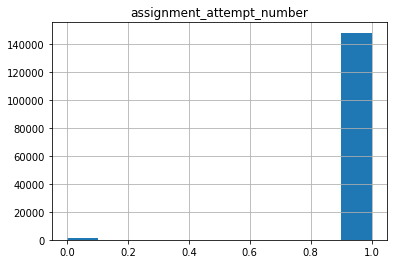

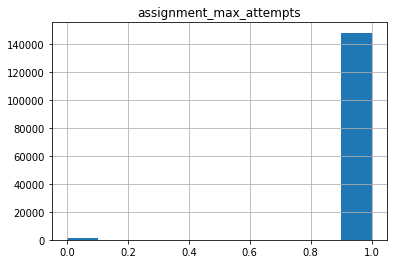

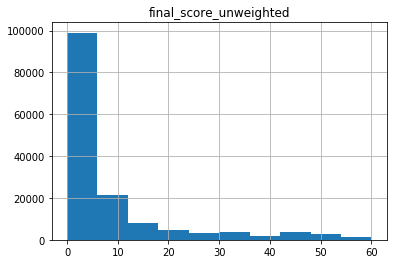

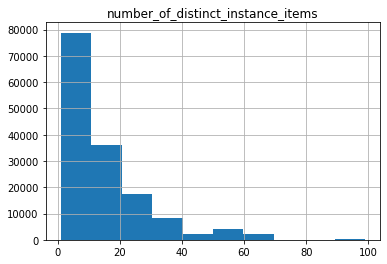

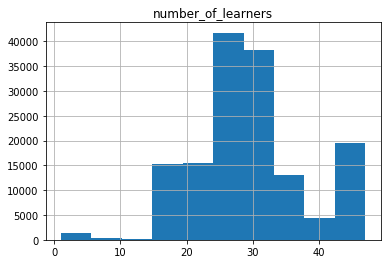

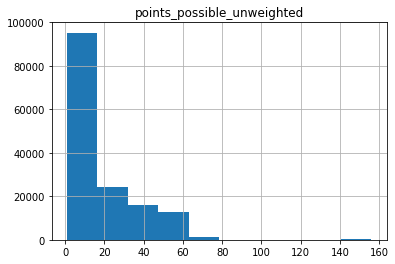

In [13]:
for f in continousFields:
  print(f)
  dfRaw.select(f).toPandas().hist()

Normal Distribution
- number_of_learners

Right Skewed
- final_score_unweighted
- number_of_distinct_instance_items
- points_possible_unweighted

Two Values (0/1)
- assignment_max_attempts
- assignment_attempt_number
- Appears binary but the variable name indicates it could have any values. The data only contains 1 and 0

In [15]:
from pyspark.sql.functions import count, when, col

for c in continousFields:
  print(c)
  dfRaw.agg(
    count(when(col(c).isNull(), c)).alias("null")
  ).show()

assignment_attempt_number
+----+
null|
+----+
 0|
+----+

assignment_max_attempts
+----+
null|
+----+
 0|
+----+

final_score_unweighted
+----+
null|
+----+
 0|
+----+

number_of_distinct_instance_items
+----+
null|
+----+
 0|
+----+

number_of_learners
+----+
null|
+----+
 0|
+----+

points_possible_unweighted
+----+
null|
+----+
 0|
+----+

In [16]:
from pyspark.sql.functions import countDistinct, count, when, col, min, max

for f in intervalFields:
  print (f)
  dfRaw.agg(
    countDistinct(f).alias("unique"), 
    count(when(col(f).isNull(), f)).alias("null"),
    min(f).alias("min"),
    max(f).alias("max")
 ).show(1, False)


assignment_due_date
+------+----+-------------------+-------------------+
unique|null|min |max |
+------+----+-------------------+-------------------+
220 |0 |2019-08-23 04:59:00|2999-01-01 00:00:00|
+------+----+-------------------+-------------------+

assignment_final_submission_date
+------+----+-------------------+-------------------+
unique|null|min |max |
+------+----+-------------------+-------------------+
230 |0 |2019-08-23 04:59:00|2999-01-01 00:00:00|
+------+----+-------------------+-------------------+

assignment_start_date
+------+----+-------------------+-------------------+
unique|null|min |max |
+------+----+-------------------+-------------------+
240 |0 |1900-01-01 00:00:00|2020-05-22 05:00:00|
+------+----+-------------------+-------------------+

max_student_stop_datetime
+------+----+-----------------------+-------------------+
unique|null|min |max |
+------+----+-----------------------+-------------------+
639 |0 |2019-08-22 04:06:27.518|2999-01-01 00:00:00|
+------+----+-----------------------+-------------------+

min_student_start_datetime
+------+----+-------------------+-----------------------+
unique|null|min |max |
+------+----+-------------------+-----------------------+
773 |0 |1900-01-01 00:00:00|2020-05-22 15:33:39.154|
+------+----+-------------------+-----------------------+

scored_datetime
+------+----+-------------------+-------------------+
unique|null|min |max |
+------+----+-------------------+-------------------+
7286 |0 |2019-08-22 02:37:58|2999-01-01 00:00:00|
+------+----+-------------------+-------------------+

student_start_datetime
+------+----+-------------------+-----------------------+
unique|null|min |max |
+------+----+-------------------+-----------------------+
10831 |0 |1900-01-01 00:00:00|2020-05-26 04:59:17.367|
+------+----+-------------------+-----------------------+

student_stop_datetime
+------+----+-----------------------+-------------------+
unique|null|min |max |
+------+----+-----------------------+-------------------+
8850 |0 |2019-08-21 23:44:42.693|2999-01-01 00:00:00|
+------+----+-----------------------+-------------------+

was_fully_scored_datetime
+------+----+-----------------------+-------------------+
unique|null|min |max |
+------+----+-----------------------+-------------------+
8657 |0 |2019-08-22 02:37:59.012|2999-01-01 00:00:00|
+------+----+-----------------------+-------------------+

was_in_progress_datetime
+------+----+-----------------------+-------------------+
unique|null|min |max |
+------+----+-----------------------+-------------------+
10731 |0 |2019-08-21 23:33:10.917|2999-01-01 00:00:00|
+------+----+-----------------------+-------------------+

was_submitted_datetime_actual
+------+----+-----------------------+-------------------+
unique|null|min |max |
+------+----+-----------------------+-------------------+
8169 |0 |2019-08-21 23:44:42.693|2999-01-01 00:00:00|
+------+----+-----------------------+-------------------+

Some dates have default values '2999-01-01 00:00:00' as max and '1900-01-01 00:00:00' as min
These are substitutes for no value and will need to be replaced nulls

In [18]:
from pyspark.sql.functions import countDistinct, count, when, col, min, max

# Categorical / Interval Variables
defaults = ["2999-01-01 00:00:00","1900-01-01 00:00:00"]

for f in intervalFields:
  print (f)
  dfRaw.agg(
    countDistinct(f).alias("unique"), 
    count( when(col(f).isNull(), f)).alias("null"),
    min( when(col(f).isin(defaults) == False, col(f) )).alias("min"),
    max( when(col(f).isin(defaults) == False, col(f) )).alias("max")
 ).show(1, False)

assignment_due_date
+------+----+-------------------+-------------------+
unique|null|min |max |
+------+----+-------------------+-------------------+
220 |0 |2019-08-23 04:59:00|2020-05-26 04:59:00|
+------+----+-------------------+-------------------+

assignment_final_submission_date
+------+----+-------------------+-------------------+
unique|null|min |max |
+------+----+-------------------+-------------------+
230 |0 |2019-08-23 04:59:00|2020-06-05 04:59:00|
+------+----+-------------------+-------------------+

assignment_start_date
+------+----+-------------------+-------------------+
unique|null|min |max |
+------+----+-------------------+-------------------+
240 |0 |2019-08-21 05:00:00|2020-05-22 05:00:00|
+------+----+-------------------+-------------------+

max_student_stop_datetime
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
639 |0 |2019-08-22 04:06:27.518|2020-05-26 06:48:38.546|
+------+----+-----------------------+-----------------------+

min_student_start_datetime
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
773 |0 |2019-08-21 23:33:10.917|2020-05-22 15:33:39.154|
+------+----+-----------------------+-----------------------+

scored_datetime
+------+----+-------------------+-------------------+
unique|null|min |max |
+------+----+-------------------+-------------------+
7286 |0 |2019-08-22 02:37:58|2020-05-26 04:59:53|
+------+----+-------------------+-------------------+

student_start_datetime
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
10831 |0 |2019-08-21 23:33:10.917|2020-05-26 04:59:17.367|
+------+----+-----------------------+-----------------------+

student_stop_datetime
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
8850 |0 |2019-08-21 23:44:42.693|2020-05-26 06:48:38.546|
+------+----+-----------------------+-----------------------+

was_fully_scored_datetime
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
8657 |0 |2019-08-22 02:37:59.012|2020-05-26 04:59:53.903|
+------+----+-----------------------+-----------------------+

was_in_progress_datetime
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
10731 |0 |2019-08-21 23:33:10.917|2020-05-26 03:30:53.599|
+------+----+-----------------------+-----------------------+

was_submitted_datetime_actual
+------+----+-----------------------+-----------------------+
unique|null|min |max |
+------+----+-----------------------+-----------------------+
8169 |0 |2019-08-21 23:44:42.693|2020-05-26 06:48:38.546|
+------+----+-----------------------+-----------------------+

Dates fall in range of a school year of 8/2019 to 5/2020

In [20]:
# Deleted records count
sqlContext.sql("SELECT count(distinct is_deleted) FROM raw_data WHERE is_deleted = true").show()


+--------------------------+
count(DISTINCT is_deleted)|
+--------------------------+
 0|
+--------------------------+

# Data Cleaning

In [22]:
dfClean = dfRaw

### Convert Default / Empty Dates to NULL

In [24]:
from pyspark.sql.functions import count, col
# Count Default / Empty Dates

for f in intervalFields:
  row = dfClean.filter( (col(f) == '2999-01-01 00:00:00') | (col(f) == '1900-01-01 00:00:00') ).select(count(f).alias("null")).collect()
  found = row[0][0]
  if (found > 0):
    print (f,"=", found)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2694961934861943> in <module> 
 2 # Count Default / Empty Dates 
 3 
 ----> 4 for f in intervalFields : 
 5 row = dfClean . filter ( ( col ( f ) == '2999-01-01 00:00:00' ) | ( col ( f ) == '1900-01-01 00:00:00' ) ) . select ( count ( f ) . alias ( "null" ) ) . collect ( ) 
 6 found = row [ 0 ] [ 0 ] 

 NameError : name 'intervalFields' is not defined

In [25]:
# Set empty dates to null
from pyspark.sql.functions import when, col

for f in intervalFields:
  dfClean = dfClean.withColumn(f, when((col(f) == '2999-01-01 00:00:00') | (col(f) == '1900-01-01 00:00:00'), None ).otherwise( col(f) ) )


In [26]:
# Count Default / Empty Dates
exists = 0
for f in intervalFields:
  row = dfClean.filter( (col(f) == '2999-01-01 00:00:00') | (col(f) == '1900-01-01 00:00:00') ).select(count(f).alias("null")).collect()
  found = row[0][0]
  if (found > 0):
    exists += 1
    print (f,"=", found)
    
if (exists == 0):
  print ("None Found")
else:
  print ("Found", exists)

None Found

All default dates converted

### Reclassify categories in item_type_code_name

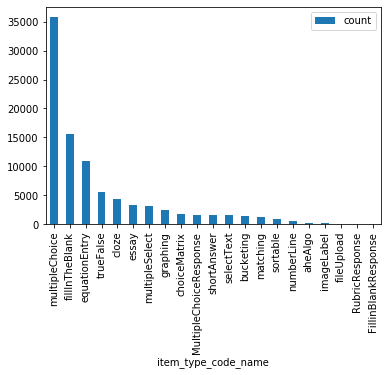

In [29]:
# Before Categories
catResults = dfClean.filter(col("item_type_code_name").isNull() == False).groupBy("item_type_code_name").count().orderBy("count", ascending=False).toPandas()
catResults.plot.bar(x='item_type_code_name', y='count')

In [30]:
from pyspark.sql.functions import col, round

tot = dfClean.filter(col("item_type_code_name").isNull() == False).count()

freqTable = dfClean.groupBy("item_type_code_name") \
               .count() \
               .withColumnRenamed('count', 'cnt_per_group') \
               .withColumn('perc_of_count_total', ( col('cnt_per_group') / tot) * 100 ) \
               .orderBy("cnt_per_group", ascending=False)

freqTable.show(50, False)

+----------------------+-------------+--------------------+
item_type_code_name |cnt_per_group|perc_of_count_total |
+----------------------+-------------+--------------------+
null |57745 |62.72403380330647 |
multipleChoice |35827 |38.916165193022096 |
fillInTheBlank |15628 |16.975516499750167 |
equationEntry |10964 |11.909365427646586 |
trueFalse |5506 |5.980752101844409 |
cloze |4244 |4.609936781734049 |
essay |3351 |3.63993830244835 |
multipleSelect |3159 |3.4313831982794203 |
graphing |2415 |2.623232169624818 |
choiceMatrix |1811 |1.9671525710933935 |
MultipleChoiceResponse|1550 |1.6836479763637546 |
shortAnswer |1526 |1.6575785883426386 |
selectText |1520 |1.6510612413373598 |
bucketing |1433 |1.5565597097608135 |
matching |1292 |1.4034020551367556 |
sortable |838 |0.9102561317373075 |
numberLine |573 |0.6224066390041494 |
aheAlgo |230 |0.24983163520236362 |
imageLabel |112 |0.1216571440985423 |
fileUpload |67 |0.0727770415589494 |
RubricResponse |11 |0.011948469509678261|
FillinBlankResponse |5 |0.005431122504399209|
+----------------------+-------------+--------------------+

Reduce dimensionality by using thresholding.  
Use the cuttoff of 3%, categorize levels with 3% or less as other

In [32]:
otherRows    = freqTable.filter("perc_of_count_total < 3")
otherFields = [row['item_type_code_name'] for row in otherRows.select("item_type_code_name").collect()]


dfClean = dfClean.withColumn("item_type_code_name", when( col("item_type_code_name").isin(otherFields), "Other" ).otherwise(col("item_type_code_name")) )

# Display new values
dfClean.groupBy("item_type_code_name").count().orderBy("count", ascending=False).show(50, False)


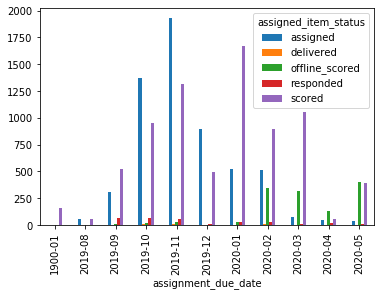

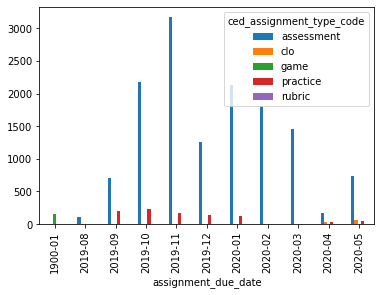

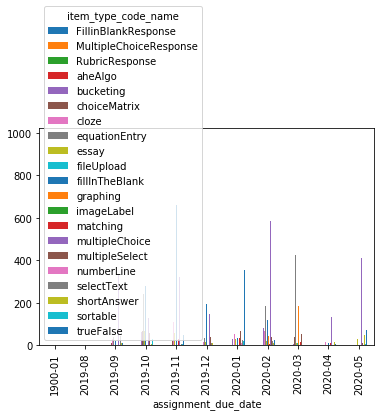

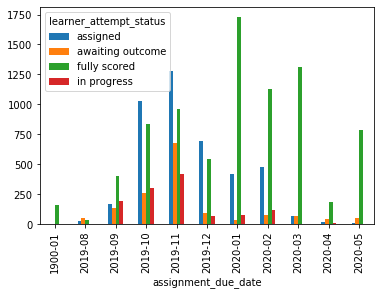

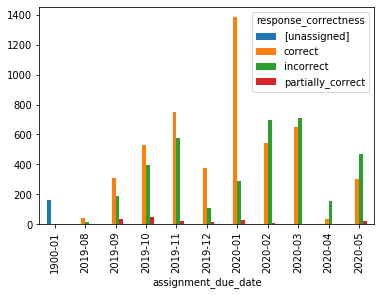

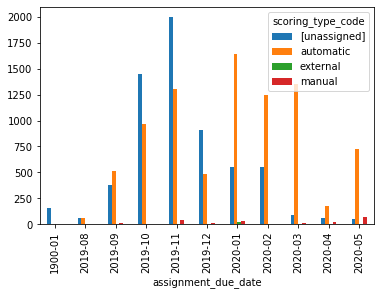

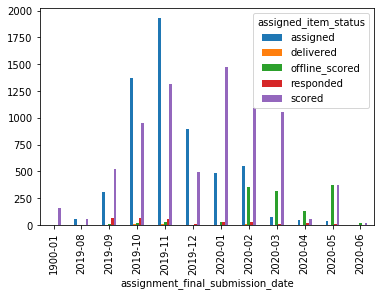

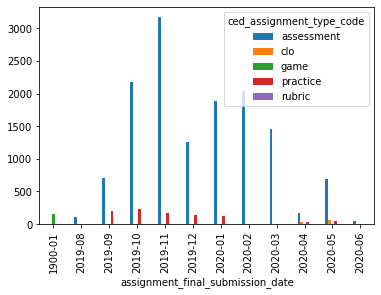

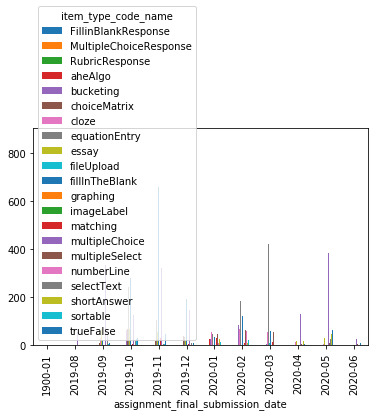

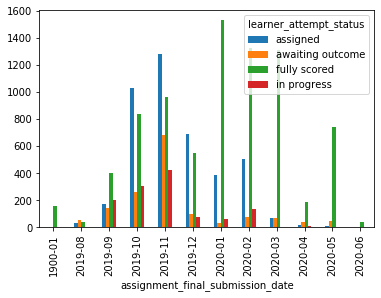

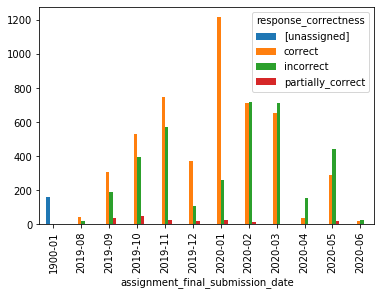

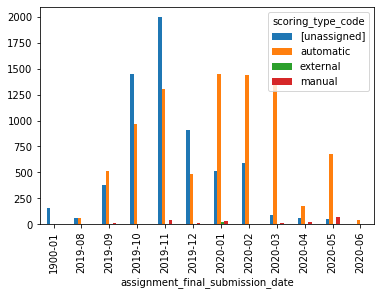

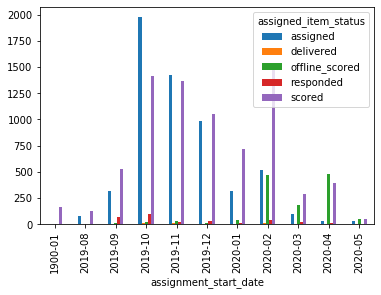

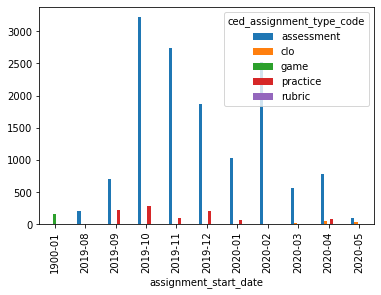

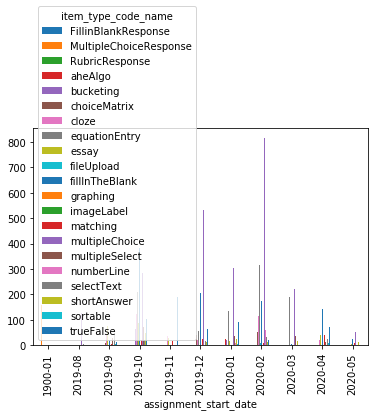

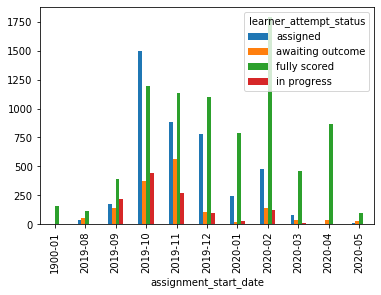

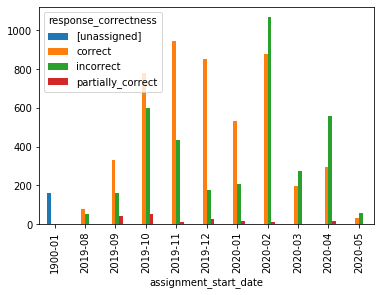

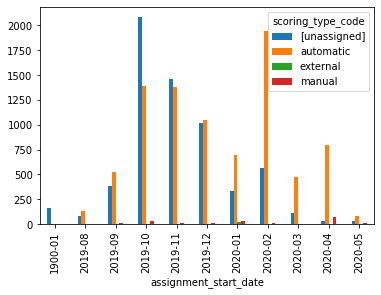

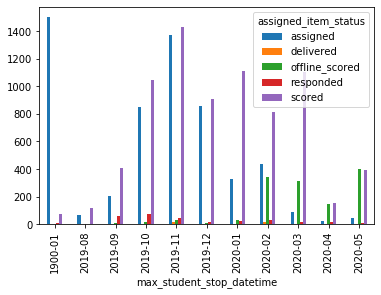

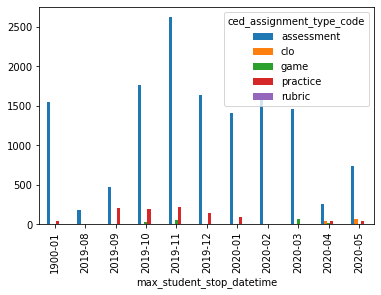

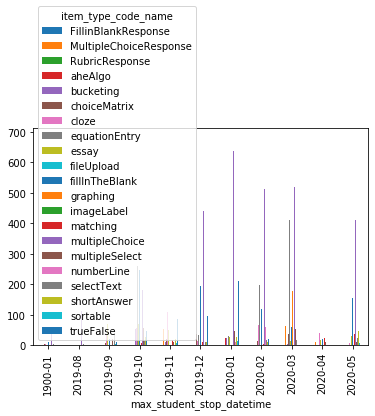

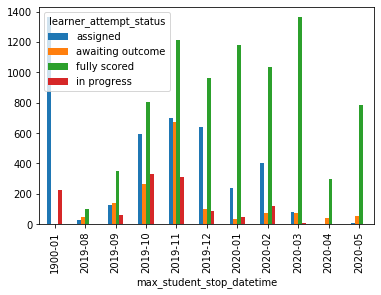

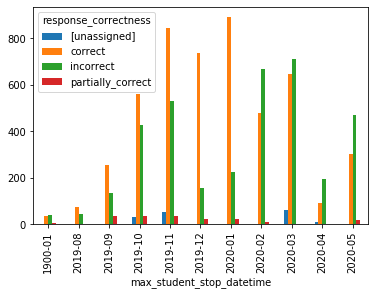

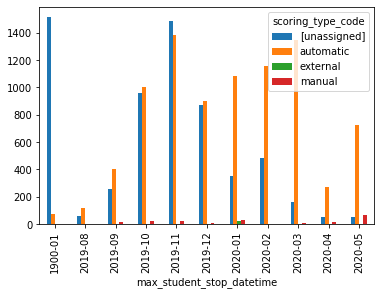

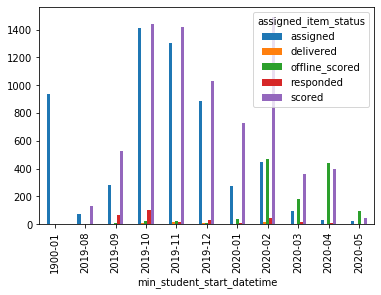

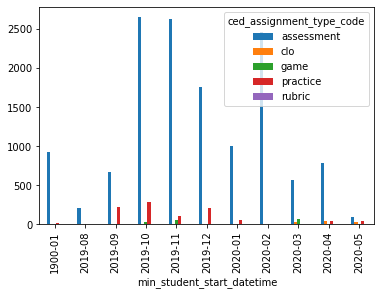

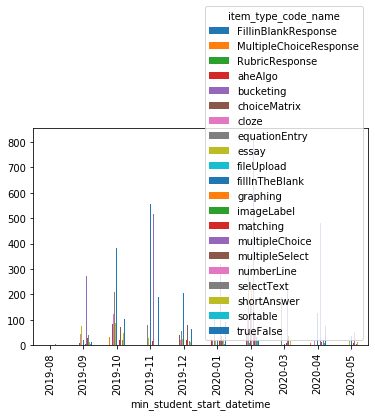

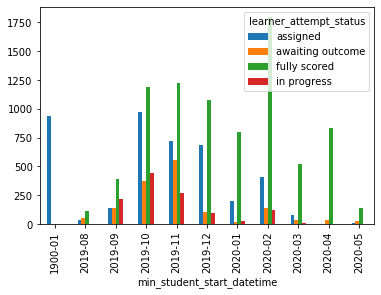

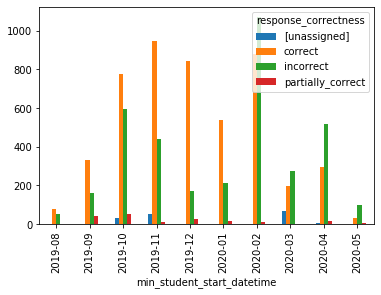

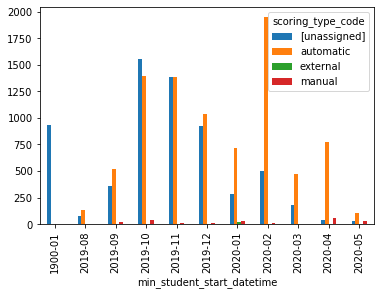

In [34]:
import pandas as pd
import numpy as np

# Check data associations to categorical data
# Use a small random sample to speed up processing
df = dfClean.sample(withReplacement=False, fraction=0.1, seed=11875884).toPandas()
for inter in intervalFields:
  for nom in nominalFields:
    print (inter, 'vs', nom)
    # Convert null dates to 1900-01-01
    df[inter] = df[inter].replace(np.nan, '1900-01-01 00:00:00', regex=True)
    # Convert date times to year month
    df[inter] = pd.to_datetime(df[inter]).map(lambda x: x.strftime('%Y-%m'))
    # Create plots
    (df
     .groupby([inter, nom])
     .size()
     .unstack()
     .plot.bar()
    )

- scoring_type_code vs min_student_start_datetime
  - "[unassigned]" is only on 1900-01
  - "[unassigned]" used when student hasn't started
  
- item_type_code_name vs min_student_start_datetime
  - never assigned to 1900-01 
  - Not assigned until student starts
  
- assignment_final_submission_date vs response_correctness
  - “[unassigned]” only on 1900-01
  - Never scored unless submitted
  
- assignment_due_date vs response_correctness
  - “[unassigned]” only on 1900-01
  - If it’s not due (maybe never assigned, it has no correctness)

- assignement_start_date & max_student_stop_datetime vs assigned_item_status 
   - 2/2020 - 5/2020 higher number of manual scored
   - Could be given a default grade because it wasn't done or no access to computer to score properly

# Data Conversion

In [37]:
%sql
